In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET
import cv2
import torch.nn.functional as F 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# 实验参考步骤
1. 从 https://monuseg.grand-challenge.org/Data/ 下载数据，训练数据下载地址：“Training Data”段落下“The dataset (images and annotations) can be downloaded using the following links- MoNuSeg 2018 Training data”，测试数据下载地址“Testing Data”段落下“Test set images with additional 7000 nuclear boundary annotations are available here MoNuSeg 2018 Testing data. ”；数据集介绍https://ieeexplore.ieee.org/document/8880654
2. 将数据集拷贝到本文件同一目录下

# 加载训练数据集

all_files ['TCGA-G9-6348-01Z-00-DX1', 'TCGA-MH-A561-01Z-00-DX1', 'TCGA-E2-A1B5-01Z-00-DX1', 'TCGA-CH-5767-01Z-00-DX1', 'TCGA-AR-A1AS-01Z-00-DX1', 'TCGA-G9-6336-01Z-00-DX1', 'TCGA-DK-A2I6-01A-01-TS1', 'TCGA-HE-7130-01Z-00-DX1', 'TCGA-A7-A13F-01Z-00-DX1', 'TCGA-G9-6356-01Z-00-DX1', 'TCGA-HE-7128-01Z-00-DX1', 'TCGA-FG-A87N-01Z-00-DX1', 'TCGA-G2-A2EK-01A-02-TSB', 'TCGA-NH-A8F7-01A-01-TS1', 'TCGA-AY-A8YK-01A-01-TS1', 'TCGA-38-6178-01Z-00-DX1', 'TCGA-A7-A13E-01Z-00-DX1', 'TCGA-HE-7129-01Z-00-DX1', 'TCGA-G9-6363-01Z-00-DX1', 'TCGA-21-5786-01Z-00-DX1', 'TCGA-18-5592-01Z-00-DX1', 'TCGA-B0-5698-01Z-00-DX1', 'TCGA-XS-A8TJ-01Z-00-DX1', 'TCGA-KB-A93J-01A-01-TS1', 'TCGA-UZ-A9PJ-01Z-00-DX1', 'TCGA-BC-A217-01Z-00-DX1', 'TCGA-G9-6362-01Z-00-DX1', 'TCGA-AR-A1AK-01Z-00-DX1', 'TCGA-RD-A8N9-01A-01-TS1', 'TCGA-B0-5711-01Z-00-DX1', 'TCGA-50-5931-01Z-00-DX1', 'TCGA-F9-A8NY-01Z-00-DX1', 'TCGA-E2-A14V-01Z-00-DX1', 'TCGA-21-5784-01Z-00-DX1', 'TCGA-49-4488-01Z-00-DX1', 'TCGA-B0-5710-01Z-00-DX1', 'TCGA-UZ-A9PN-01Z

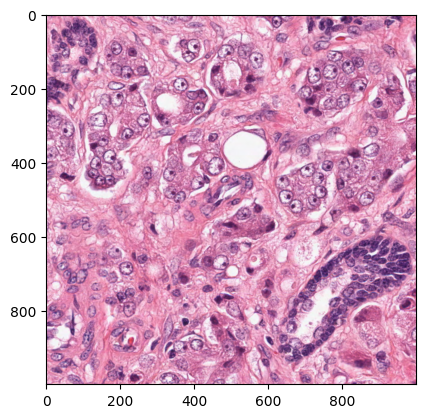

In [2]:
# 用这个方法可以找到所有的数据名称
folder_path = "/root/exercise3/MoNuSeg 2018 Training Data/Tissue Images"
all_files = os.listdir(folder_path)
all_files = [filename[:-4] for filename in all_files]
print("all_files", all_files)

x_train = []
for file in all_files:
    img = plt.imread("/root/exercise3/MoNuSeg 2018 Training Data/Tissue Images/"+file+".tif")
    x_train.append(img)

x_train = np.array(x_train, dtype=np.float32)/255. # 这个是之后要用的训练集细胞图像
print(x_train.shape)
plt.imshow(x_train[0,:,:,:])


In [3]:
# 一个用来把 xml 转化为图像的函数


def xml_to_mask(xml_path, image_shape):
    mask = np.zeros(image_shape, dtype=np.uint8)
    
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        for annotation in root.findall('Annotation'):
            for region in annotation.findall('Regions/Region'):
                vertices = []
                for vertex in region.findall('Vertices/Vertex'):
                    x = float(vertex.get('X'))
                    y = float(vertex.get('Y'))
                    vertices.append([x, y])
                
                if len(vertices) > 2:  # Need at least 3 points for a polygon
                    vertices = np.array(vertices, dtype=np.int32)
                    cv2.fillPoly(mask, [vertices], color=1)
                    
    except Exception as e:
        print(f"Error processing {xml_path}: {str(e)}")
    
    return mask

(37, 1000, 1000, 1)


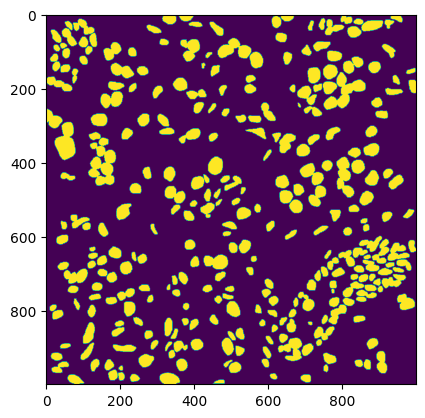

In [4]:
y_train = []
for file in all_files:
    mask = xml_to_mask("/root/exercise3/MoNuSeg 2018 Training Data/Annotations/"+file+".xml", (x_train.shape[1],x_train.shape[2],1))
    y_train.append(mask)
y_train = np.array(y_train, dtype=np.float32) # 这个是之后要用的训练集细胞图分割结果
print(y_train.shape)
plt.imshow(y_train[0,:,:])

(333, 256, 256, 3) (333, 256, 256, 1)


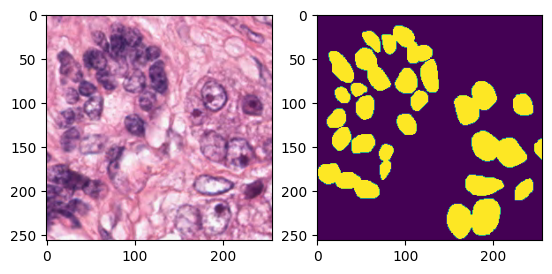

In [5]:
# 图像太大了，可以分成小块进行训练
x_train_patch = []
y_train_patch = []
for k in range(x_train.shape[0]):
    for i in range(3):
        for j in range(3):
            x_train_patch.append(x_train[k,i*256:(i+1)*256,j*256:(j+1)*256,:])
            y_train_patch.append(y_train[k,i*256:(i+1)*256,j*256:(j+1)*256,:])
x_train_patch = np.array(x_train_patch)
y_train_patch = np.array(y_train_patch)
print(x_train_patch.shape, y_train_patch.shape)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(x_train_patch[0,:,:,:])
plt.subplot(1,2,2)
plt.imshow(y_train_patch[0,:,:,:])

In [6]:
# 得到训练集的 dataloader

# Data loaders
batch_size = 16

x_train_patch = np.transpose(x_train_patch, (0, 3, 1, 2))
y_train_patch = np.transpose(y_train_patch, (0, 3, 1, 2))
print(x_train_patch.shape, y_train_patch.shape)

train_dataset = TensorDataset(torch.tensor(x_train_patch), torch.tensor(y_train_patch))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

(333, 3, 256, 256) (333, 1, 256, 256)


# 练习：加载测试数据集
请仿照上面的步骤，创建测试集的dataloader

all_test_files ['TCGA-IZ-8196-01A-01-BS1', 'TCGA-69-7764-01A-01-TS1', 'TCGA-HT-8564-01Z-00-DX1', 'TCGA-A6-6782-01A-01-BS1', 'TCGA-ZF-A9R5-01A-01-TS1', 'TCGA-44-2665-01B-06-BS6', 'TCGA-FG-A4MU-01B-01-TS1', 'TCGA-2Z-A9J9-01A-01-TS1', 'TCGA-GL-6846-01A-01-BS1', 'TCGA-HC-7209-01A-01-TS1', 'TCGA-EJ-A46H-01A-03-TSC', 'TCGA-AO-A0J2-01A-01-BSA', 'TCGA-CU-A0YN-01A-02-BSB', 'TCGA-AC-A2FO-01A-01-TS1']
(14, 1000, 1000, 3)


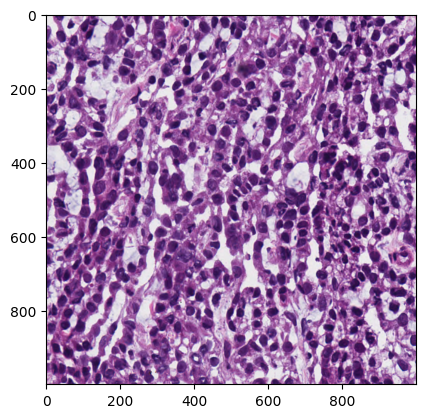

In [7]:
test_folder_path = "/root/exercise3/MoNuSegTestData/"
all_test_files = os.listdir(test_folder_path)
all_test_files = [filename[:-4] for filename in all_test_files if filename.endswith(".tif")]
print("all_test_files", all_test_files)

x_test = []
for file in all_test_files: 
    img = plt.imread(test_folder_path + file + ".tif") 
    x_test.append(img)

x_test = np.array(x_test, dtype=np.float32)/255. #测试集细胞图像
print(x_test.shape)
plt.imshow(x_test[0,:,:,:])
   

(14, 1000, 1000, 1)


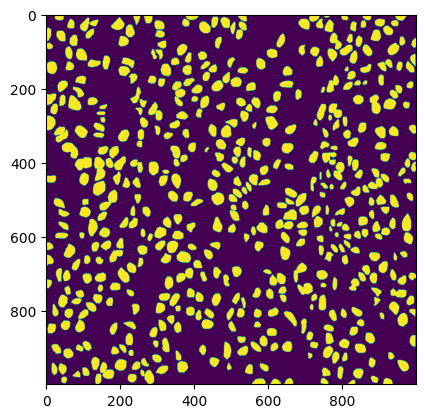

In [8]:
y_test = []
for file in all_test_files:
    mask = xml_to_mask("/root/exercise3/MoNuSegTestData/"+file+".xml", (x_test.shape[1],x_test.shape[2],1))
    y_test.append(mask)
y_test = np.array(y_test, dtype=np.float32) #测试集细胞图分割效果
print(y_test.shape)
plt.imshow(y_test[0,:,:])

(126, 256, 256, 3) (126, 256, 256, 1)


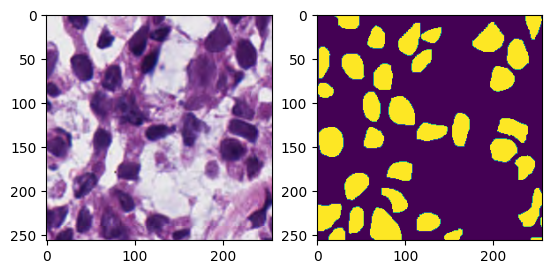

In [9]:
x_test_patch = []
y_test_patch = []
for k in range(x_test.shape[0]):
    for i in range(3):
        for j in range(3):
            x_test_patch.append(x_test[k,i*256:(i+1)*256,j*256:(j+1)*256,:])
            y_test_patch.append(y_test[k,i*256:(i+1)*256,j*256:(j+1)*256,:])
x_test_patch = np.array(x_test_patch)
y_test_patch = np.array(y_test_patch)
print(x_test_patch.shape, y_test_patch.shape)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(x_test_patch[0,:,:,:])
plt.subplot(1,2,2)
plt.imshow(y_test_patch[0,:,:,:])

In [10]:
Batch_size = 16

x_test_patch = np.transpose(x_test_patch, (0, 3, 1, 2))
y_test_patch = np.transpose(y_test_patch, (0, 3, 1, 2))
print(x_test_patch.shape, y_test_patch.shape)

test_dataset = TensorDataset(torch.tensor(x_test_patch), torch.tensor(y_test_patch))
test_loader = DataLoader(test_dataset, batch_size=Batch_size, shuffle=True)

(126, 3, 256, 256) (126, 1, 256, 256)


In [12]:
class Unet(nn.Module):
    def __init__(self, n_class, p_dropout=0.2):
        super().__init__()
        
        # Encoder
        
        self.e11 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(32)
        self.e12 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 添加dropout
        self.dropout = nn.Dropout2d(p=p_dropout)
        self.e21 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(64)
        self.e22 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(128)
        self.e32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(256)
        self.e42 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn51 = nn.BatchNorm2d(512)
        self.e52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52 = nn.BatchNorm2d(512)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn_d11 = nn.BatchNorm2d(256)
        self.d12 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn_d12 = nn.BatchNorm2d(256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn_d21 = nn.BatchNorm2d(128)
        self.d22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn_d22 = nn.BatchNorm2d(128)

        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn_d31 = nn.BatchNorm2d(64)
        self.d32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn_d32 = nn.BatchNorm2d(64)

        self.upconv4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.bn_d41 = nn.BatchNorm2d(32)
        self.d42 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn_d42 = nn.BatchNorm2d(32)

        self.outconv = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = F.relu(self.bn11(self.e11(x)))
        xe12 = F.relu(self.bn12(self.e12(xe11)))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.bn21(self.e21(xp1)))
        xe22 = F.relu(self.bn22(self.e22(xe21)))
        xe22 = self.dropout(xe22)  
        xp2 = self.pool2(xe22)

        xe31 = F.relu(self.bn31(self.e31(xp2)))
        xe32 = F.relu(self.bn32(self.e32(xe31)))
        xe32 = self.dropout(xe32)  
        xp3 = self.pool3(xe32)

        xe41 = F.relu(self.bn41(self.e41(xp3)))
        xe42 = F.relu(self.bn42(self.e42(xe41)))
        xe42 = self.dropout(xe42)  
        xp4 = self.pool4(xe42)

        xe51 = F.relu(self.bn51(self.e51(xp4)))
        xe52 = F.relu(self.bn52(self.e52(xe51)))
        xe52 = self.dropout(xe52)  
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = F.relu(self.bn_d11(self.d11(xu11)))
        xd12 = F.relu(self.bn_d12(self.d12(xd11)))
        xd12 = self.dropout(xd12)  

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = F.relu(self.bn_d21(self.d21(xu22)))
        xd22 = F.relu(self.bn_d22(self.d22(xd21)))
        xd22 = self.dropout(xd22)  

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = F.relu(self.bn_d31(self.d31(xu33)))
        xd32 = F.relu(self.bn_d32(self.d32(xd31)))
        xd32 = self.dropout(xd32)  

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = F.relu(self.bn_d41(self.d41(xu44)))
        xd42 = F.relu(self.bn_d42(self.d42(xd41)))

        out = self.outconv(xd42)

        return out

 

# 练习：完成模型训练部分的代码

In [18]:

model=Unet(1)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 20
train_losses, test_losses = [], []

#模型训练
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # 评估
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    
    print(
        f"Epoch {epoch+1}/{epochs}, "
        f"Train Loss: {epoch_loss:.4f}, "
        f"Test Loss: {test_loss:.4f}, "
        )



torch.save(model, "./model_1.pt")

Epoch 1/20, Train Loss: 0.5616, Test Loss: 0.6322, 
Epoch 2/20, Train Loss: 0.4618, Test Loss: 0.4065, 
Epoch 3/20, Train Loss: 0.4184, Test Loss: 0.3610, 
Epoch 4/20, Train Loss: 0.3964, Test Loss: 0.3791, 
Epoch 5/20, Train Loss: 0.3821, Test Loss: 0.3587, 
Epoch 6/20, Train Loss: 0.3719, Test Loss: 0.3581, 
Epoch 7/20, Train Loss: 0.3617, Test Loss: 0.3568, 
Epoch 8/20, Train Loss: 0.3560, Test Loss: 0.3506, 
Epoch 9/20, Train Loss: 0.3480, Test Loss: 0.3335, 
Epoch 10/20, Train Loss: 0.3444, Test Loss: 0.3729, 
Epoch 11/20, Train Loss: 0.3379, Test Loss: 0.3440, 
Epoch 12/20, Train Loss: 0.3312, Test Loss: 0.3208, 
Epoch 13/20, Train Loss: 0.3263, Test Loss: 0.3342, 
Epoch 14/20, Train Loss: 0.3226, Test Loss: 0.3101, 
Epoch 15/20, Train Loss: 0.3140, Test Loss: 0.3119, 
Epoch 16/20, Train Loss: 0.3093, Test Loss: 0.3096, 
Epoch 17/20, Train Loss: 0.3051, Test Loss: 0.3055, 
Epoch 18/20, Train Loss: 0.2989, Test Loss: 0.3131, 
Epoch 19/20, Train Loss: 0.2954, Test Loss: 0.3032, 
Ep

遇到了显存不足问题，将计算iou转移到cpu上，在评估部分进行了分批处理，预测时不计算梯度，每个批次处理完清理显存（用了一点ai）

In [19]:

def iou(preds, targets):
       preds = (preds > 0.5).cpu()  
       targets = targets.cpu()
       preds = preds.view(-1)
       targets = targets.view(-1)
       intersection = (preds * targets).sum()
       union = preds.sum() + targets.sum() - intersection
       return (intersection / union).item()  

x_train_tensor = torch.tensor(x_train_patch)
y_train_tensor = torch.tensor(y_train_patch)
num_samples = x_train_tensor.shape[0]

ious = []
with torch.no_grad():  
       for i in range(0, num_samples, batch_size):
           batch_x = x_train_tensor[i:i+batch_size].to(device)
           batch_y = y_train_tensor[i:i+batch_size].to(device)
           
    
           batch_preds = model(batch_x)
           for j in range(batch_preds.shape[0]):
               iou_val = iou(batch_preds[j:j+1], batch_y[j:j+1])
               ious.append(iou_val)
           
           #清理显存
           del batch_preds
           torch.cuda.empty_cache()

ious = np.array(ious)
print(ious)
print(np.mean(ious))




[0.59195405 0.57336462 0.6045773  0.4809266  0.62514764 0.49790844
 0.6104157  0.60747182 0.60947746 0.63010305 0.69288373 0.70418215
 0.66371644 0.68936121 0.69550675 0.69686794 0.6689437  0.63709027
 0.48660189 0.56979591 0.45061615 0.62452942 0.55781543 0.59775901
 0.59736329 0.45266479 0.58121043 0.65689272 0.66010672 0.70080352
 0.71346563 0.66585112 0.63590294 0.69544405 0.52455777 0.60492724
 0.6978054  0.61364126 0.55690861 0.68239349 0.66612464 0.73099285
 0.64530808 0.73708045 0.73396885 0.47810996 0.65243012 0.55266571
 0.5581094  0.58228093 0.57360601 0.62839907 0.57410145 0.66695297
 0.79505605 0.81064022 0.78875548 0.78959316 0.78533334 0.73687577
 0.75477433 0.77160609 0.71137261 0.69483334 0.6732465  0.69269913
 0.69061542 0.66750723 0.63929015 0.68568313 0.58454597 0.58636636
 0.7170192  0.74058509 0.74714518 0.76815712 0.68916565 0.71825355
 0.63306129 0.61486685 0.70028865 0.60897213 0.58910799 0.64742684
 0.5811159  0.65424639 0.59416747 0.61762965 0.65437543 0.5623

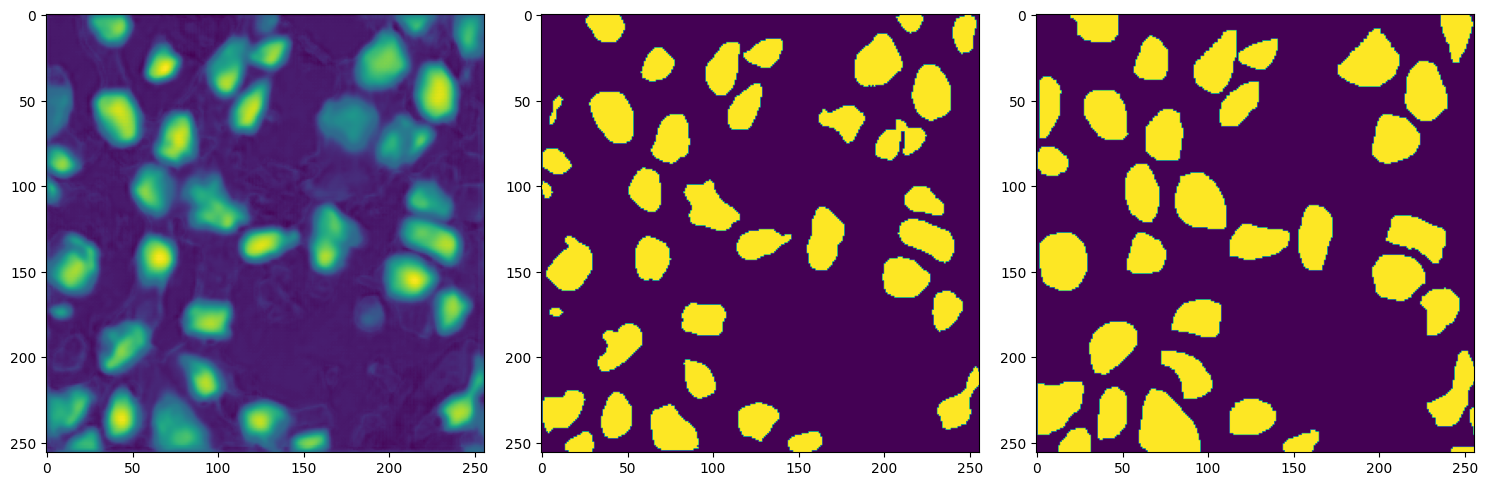

In [20]:


x_train = torch.tensor(x_test_patch[0:1]).to(device)  
y_train = torch.tensor(y_test_patch[0:1]).to(device)
pred = model(x_train)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(pred.cpu().detach().numpy()[0, 0, :, :])
plt.subplot(1, 3, 2)
plt.imshow(pred.cpu().detach().numpy()[0, 0, :, :] > 0.5)
plt.subplot(1, 3, 3)
plt.imshow(y_train.cpu().detach().numpy()[0, 0, :, :])
plt.tight_layout()
plt.show()
  

# 练习：完成模型测试部分

In [21]:
x_test_tensor = torch.tensor(x_test_patch)
y_test_tensor = torch.tensor(y_test_patch)
num_samples = x_train_tensor.shape[0]

ious_test = []
with torch.no_grad():  
       for i in range(0, num_samples, batch_size):
           batch_x = x_test_tensor[i:i+batch_size].to(device)
           batch_y = y_test_tensor[i:i+batch_size].to(device)
           
    
           batch_preds = model(batch_x)
           for j in range(batch_preds.shape[0]):
               iou_val = iou(batch_preds[j:j+1], batch_y[j:j+1])
               ious_test.append(iou_val)
           
           #清理显存
           del batch_preds
           torch.cuda.empty_cache()

ious_test = np.array(ious_test)
print(ious_test)
print(np.mean(ious_test))

[0.66683036 0.66610676 0.58853859 0.70098829 0.65826315 0.66050583
 0.67066383 0.62032723 0.6912601  0.49497402 0.50246364 0.56482828
 0.50354004 0.40695167 0.51731569 0.44776228 0.49269193 0.53639656
 0.58724016 0.44127831 0.47206977 0.41057378 0.41829258 0.4969497
 0.55740142 0.42867696 0.68112063 0.50005281 0.61767793 0.4744097
 0.57513267 0.52744651 0.59425819 0.49203134 0.58402205 0.61073154
 0.79993927 0.79763818 0.74439788 0.75149643 0.76847327 0.79475296
 0.78764665 0.77728033 0.78089982 0.7082954  0.63109183 0.64852506
 0.61699581 0.63751793 0.61877722 0.72414529 0.67124057 0.68559307
 0.72933042 0.71026498 0.68062943 0.68089521 0.73688269 0.68820435
 0.75060767 0.6809572  0.66795838 0.63457084 0.65773129 0.6655758
 0.69962364 0.71107799 0.65725905 0.67587286 0.64739811 0.61960202
 0.52400512 0.52363336 0.56943405 0.50672114 0.4148249  0.44603184
 0.53686613 0.53866947 0.51121885 0.50540692 0.61220664 0.55996615
 0.52363789 0.5826717  0.68437749 0.53334612 0.55045199 0.6493485

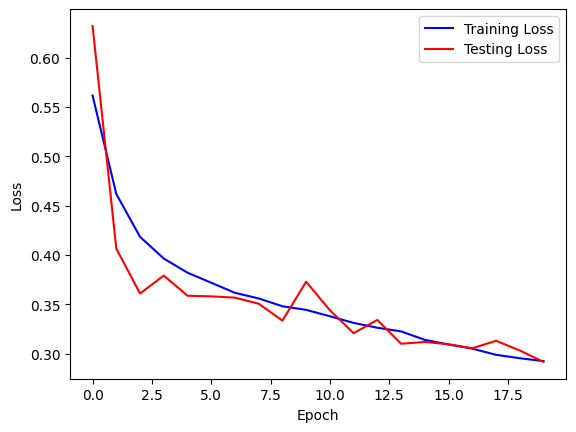

In [22]:
plt.plot(train_losses, label="Training Loss",color="blue")
plt.plot(test_losses, label="Testing Loss",color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 练习要求
训练模型至少达到上面的效果。可通过增加训练轮数、改变模型结构(paper with code)、增加transform等方式

使用显卡训练 https://www.autodl.com/login